In [0]:
!nvidia-smi

Thu May 28 13:46:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 665kB 6.2MB/s 
     |████████████████████████████████| 3.8MB 40.4MB/s 
     |████████████████████████████████| 1.1MB 38.8MB/s 
     |████████████████████████████████| 890kB 42.3MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/204-roBERTa_base/'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [0]:
import json, warnings, shutil
from scripts_step_lr_schedulers import *
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 120)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [0]:
# Unzip files
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_1.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_2.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_3.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_4.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_5.tar.gz'

In [0]:
database_base_path = COLAB_BASE_PATH + 'Data/complete_64_clean/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
print(f'Training samples: {len(k_fold)}')
display(k_fold.head())

Training samples: 26882


,textID,text,selected_text,sentiment,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt,fold_1,fold_2,fold_3,fold_4,fold_5,imputed
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,7,10,35,7,10,train,validation,train,train,train,False
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,10,13,8,2,3,validation,train,train,train,train,False
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,5,6,11,2,2,train,train,train,validation,train,False
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,5,6,14,3,3,train,train,train,validation,train,False
4,358bd9e861,"sons of ****, why couldn`t they put them on the releases we already bought","sons of ****,",negative,0.214286,74,14,17,13,3,4,train,train,train,validation,train,False


# Model parameters

In [0]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

config = {
  "MAX_LEN": 64,
  "BATCH_SIZE": 32,
  "EPOCHS": 4,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 4,
  "N_FOLDS": 5,
  "question_size": 4,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 4.39e-06


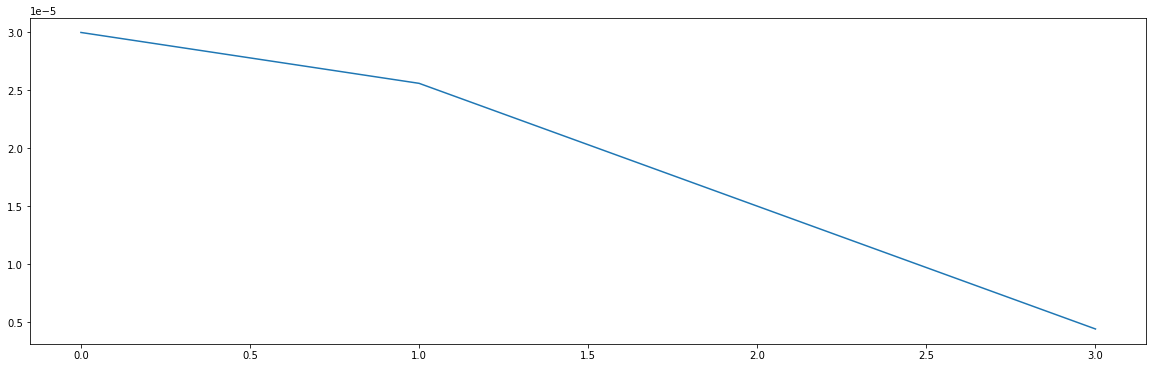

In [0]:
LR_MIN = 1e-6
LR_MAX = config['LEARNING_RATE']
lr_start=1e-4
warmup_epochs=0
hold_max_epochs=0
num_cycles=0.5
total_epochs = config['EPOCHS']

@tf.function
def lrfn(epoch):
    if epoch < warmup_epochs:
        lr = (LR_MAX - lr_start) / (warmup_epochs * epoch) + lr_start
    elif epoch < warmup_epochs + hold_max_epochs:
        lr = LR_MAX
    else:
        progress = (epoch - warmup_epochs - hold_max_epochs) / (total_epochs - warmup_epochs - hold_max_epochs)
        lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(np.pi * num_cycles * 2.0 * progress)))
        if LR_MIN is not None:
            lr = tf.math.maximum(LR_MIN, lr)
            
    return lr
    
rng = [i for i in range(config['EPOCHS'])]
y = [lrfn(x) for x in rng]

fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})

    x = layers.Dropout(.1)(last_hidden_state)
    
    x_start = layers.Dense(1)(x)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)

    x_end = layers.Dense(1)(x)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    return model

# Train

In [0]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
k_fold_best = k_fold.copy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    base_data_path = 'fold_%d/' % (n_fold)

    # Load data
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']

    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss_start = loss_fn(y['y_start'], probabilities[0], label_smoothing=0.2)
                loss_end = loss_fn(y['y_end'], probabilities[1], label_smoothing=0.2)
                loss = tf.math.add(loss_start, loss_end)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # update metrics
            train_loss.update_state(loss)
            train_loss_start.update_state(loss_start)
            train_loss_end.update_state(loss_end)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss_start = loss_fn(y['y_start'], probabilities[0])
            loss_end = loss_fn(y['y_end'], probabilities[1])
            loss = tf.math.add(loss_start, loss_end)
            # update metrics
            valid_loss.update_state(loss)
            valid_loss_start.update_state(loss_start)
            valid_loss_end.update_state(loss_end)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)//step_size))
    loss_fn = losses.categorical_crossentropy
    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    train_loss_start = metrics.Sum()
    valid_loss_start = metrics.Sum()
    train_loss_end = metrics.Sum()
    valid_loss_end = metrics.Sum()
        
    metrics_dict = {'loss': train_loss, 'loss_start': train_loss_start, 'loss_end': train_loss_end, 
                    'val_loss': valid_loss, 'val_loss_start': valid_loss_start, 'val_loss_end': valid_loss_end}
        
    history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                         step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], 
                         (MODEL_BASE_PATH + model_path), save_last=False)
    
    history_list.append(history)
    
    # Make predictions
    model.load_weights(MODEL_BASE_PATH + model_path)
    predict_eval_df(k_fold, model, x_train, x_valid, get_test_dataset, decode, n_fold, tokenizer, config, config['question_size'])


FOLD: 1
Train for 672 steps, validate for 168 steps
Instructions for updating:
renamed to `run`

EPOCH 1/4
time: 188.1s loss: 4.1531 loss_start: 2.0701 loss_end: 2.0830 val_loss: 1.9097 val_loss_start: 0.9964 val_loss_end: 0.9133
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/204-roBERTa_base/model_fold_1.h5"

EPOCH 2/4
time: 175.5s loss: 3.7635 loss_start: 1.9000 loss_end: 1.8635 val_loss: 1.9110 val_loss_start: 0.9781 val_loss_end: 0.9330

EPOCH 3/4
time: 173.3s loss: 3.6252 loss_start: 1.8328 loss_end: 1.7925 val_loss: 1.8901 val_loss_start: 0.9866 val_loss_end: 0.9034
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/204-roBERTa_base/model_fold_1.h5"

EPOCH 4/4
time: 177.4s loss: 3.5242 loss_start: 1.7828 loss_end: 1.7415 val_loss: 1.9119 val_loss_start: 0.9992 val_loss_end: 0.9127
Training finished

FOLD: 2
Train for 672 steps, validate for 168 steps

EPOCH 1/4
time: 187

# Model loss graph

Fold: 1


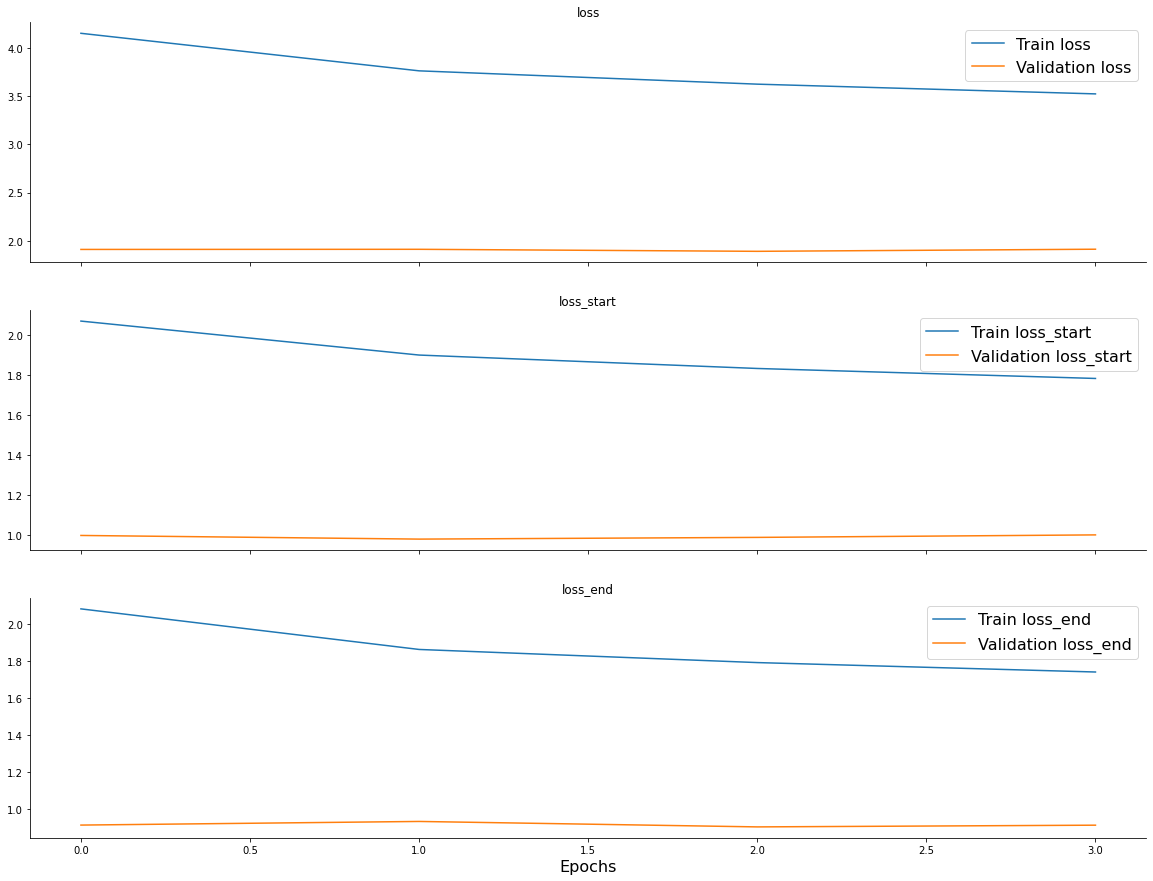

Fold: 2


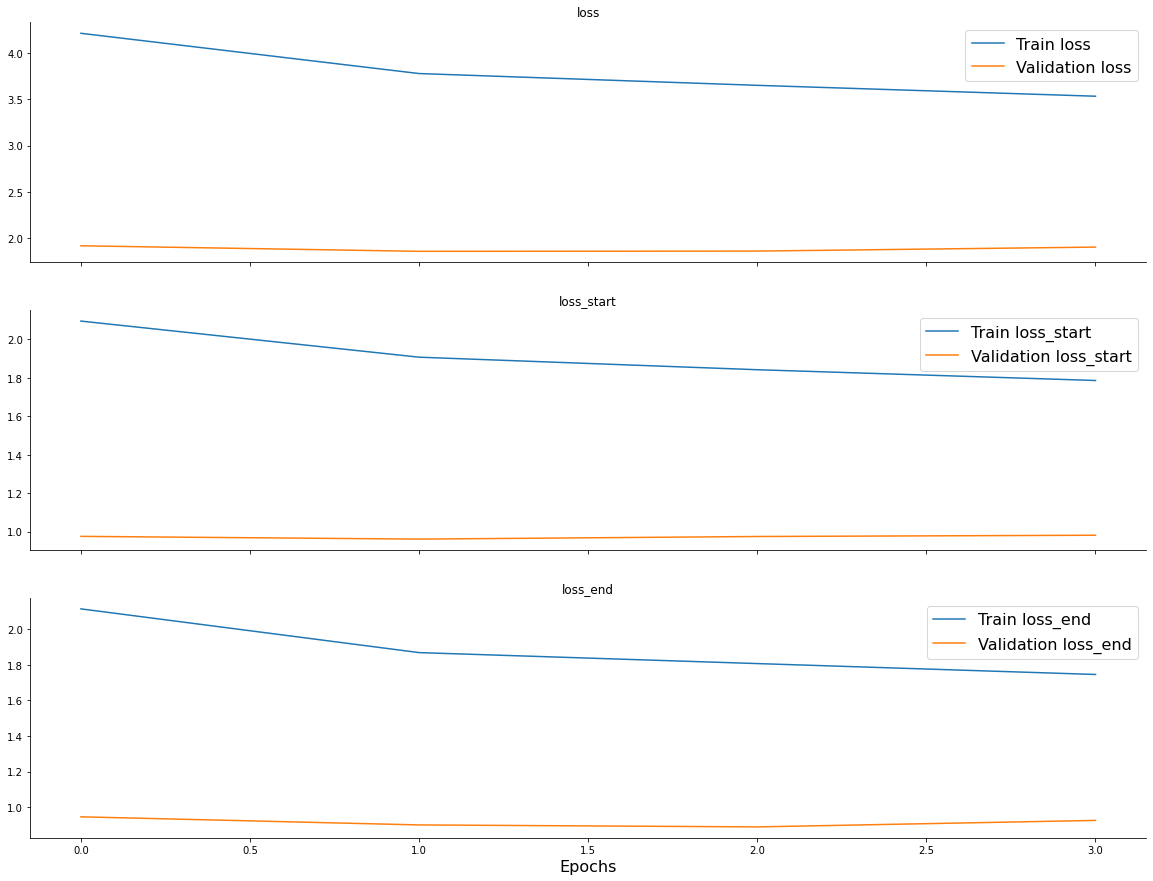

Fold: 3


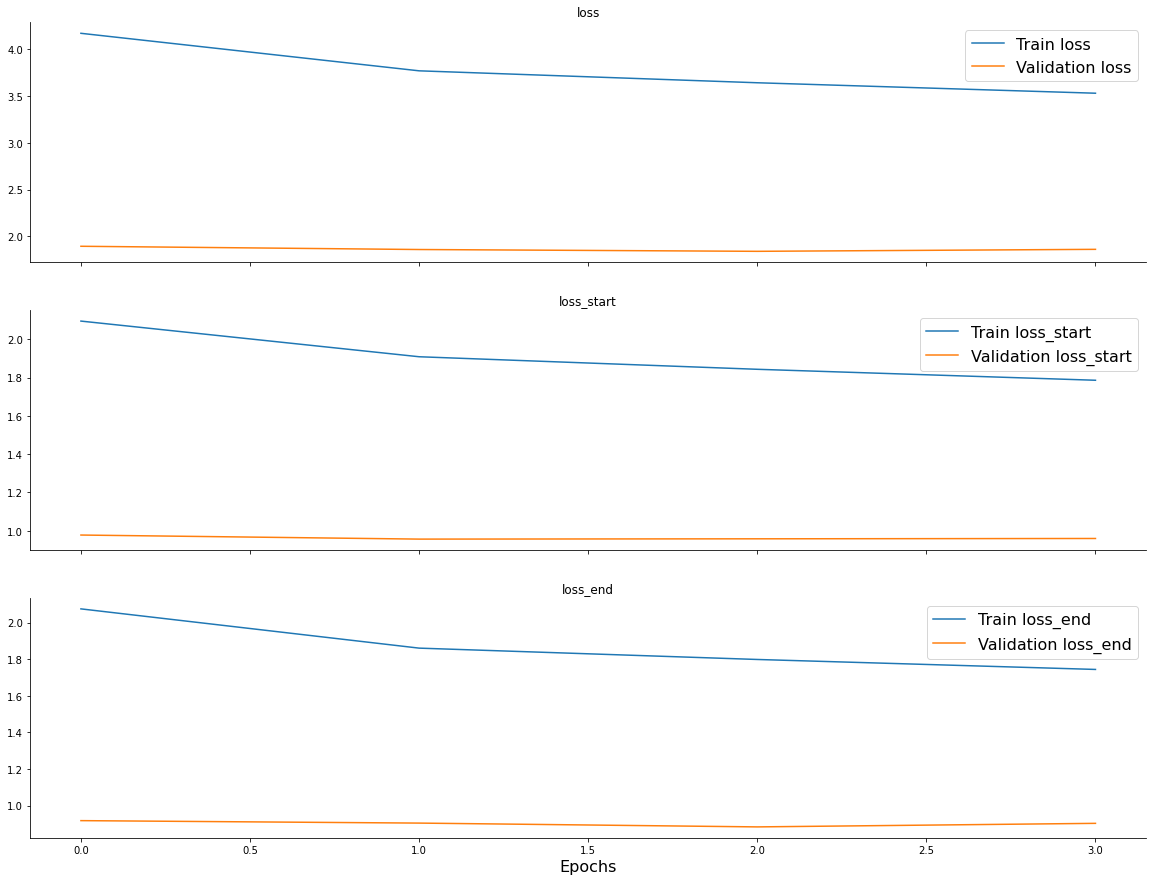

Fold: 4


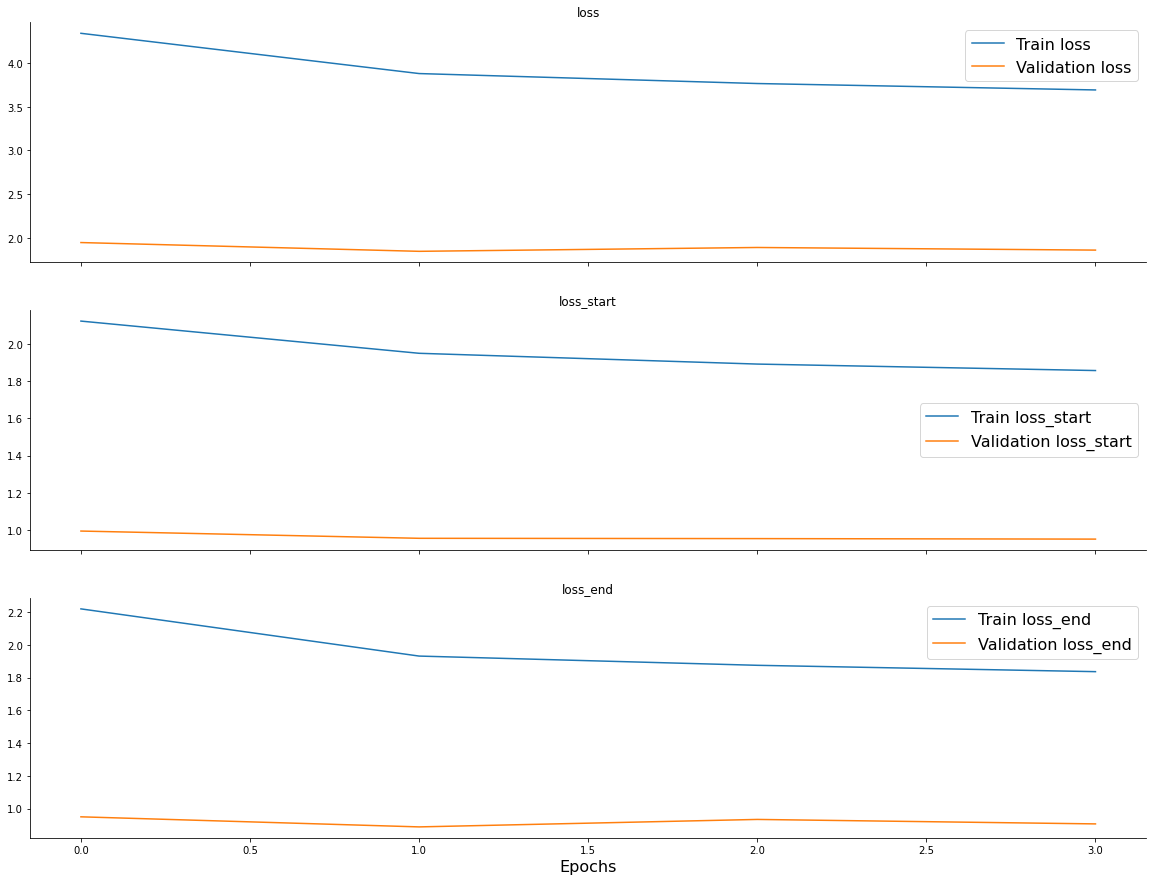

Fold: 5


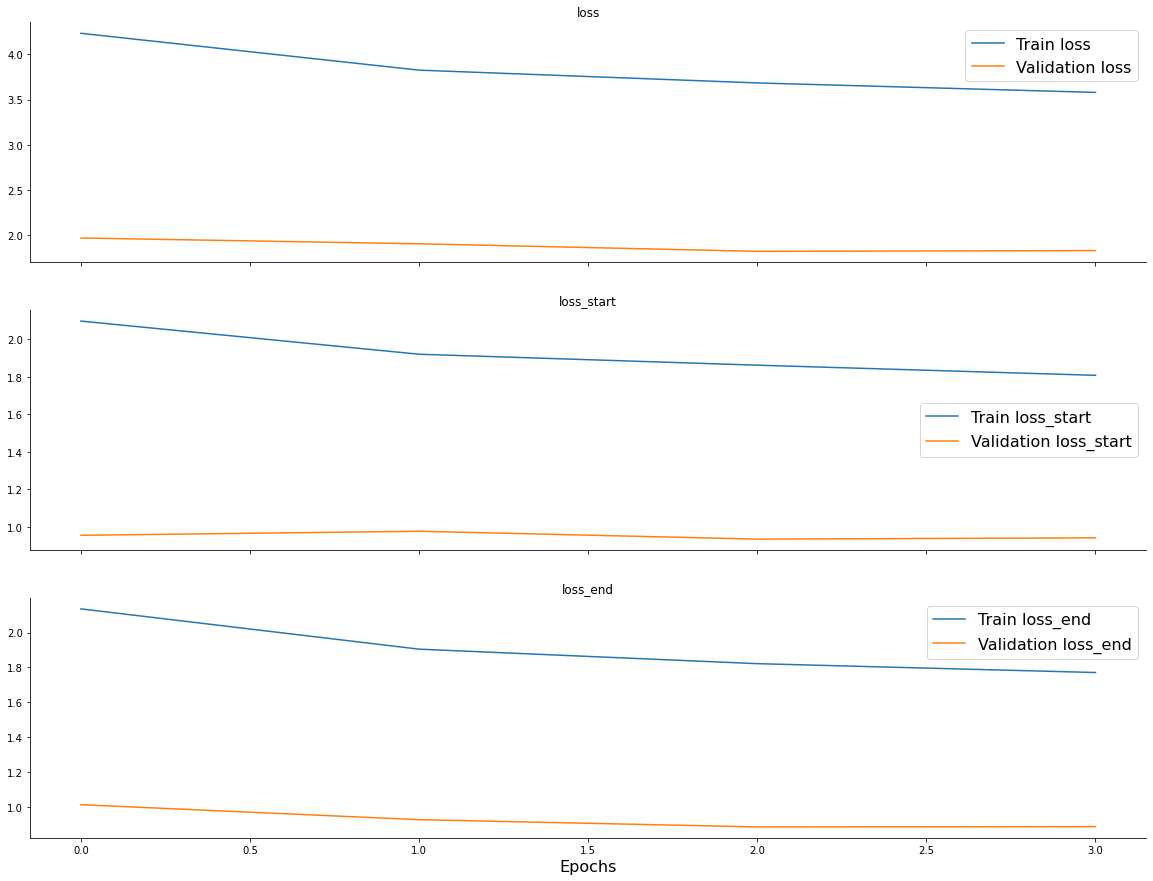

In [0]:
#@title
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [0]:
#@title
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.763995,0.720548,0.043447,0.779181,0.727411,0.757439,0.720207,0.778794,0.715030,0.740383,0.722818,0.764180,0.717274
Sentiment negative,0.625147,0.542958,0.082189,0.654930,0.554432,0.606977,0.536530,0.649501,0.546490,0.584768,0.541212,0.629559,0.536127
Sentiment neutral,0.977388,0.975895,0.001493,0.977990,0.973987,0.976736,0.976854,0.978322,0.975177,0.976655,0.976321,0.977236,0.977138
Sentiment positive,0.603653,0.539034,0.064619,0.625193,0.553394,0.599710,0.542369,0.628378,0.518947,0.564534,0.547471,0.600451,0.532992
0 <= text tokens < 3,0.960831,0.960145,0.000686,0.968889,0.959677,0.962719,0.940678,0.956897,0.972727,0.953947,0.966102,0.961702,0.961538
3 <= text tokens < 15,0.811691,0.781893,0.029799,0.824020,0.790722,0.805706,0.784043,0.822952,0.775960,0.794710,0.777589,0.811068,0.781149
15 <= text tokens < 30,0.735038,0.683978,0.051061,0.750152,0.696217,0.729241,0.677626,0.752710,0.677503,0.708962,0.685177,0.734126,0.683367
30 <= text tokens < 45,0.707069,0.645625,0.061444,0.730308,0.631546,0.698112,0.649365,0.724476,0.643928,0.670900,0.670610,0.711547,0.632675
45 <= text tokens < 120,0.788806,0.774834,0.013972,0.811829,0.837051,0.762083,0.791935,0.825814,0.560239,0.765564,0.825871,0.778741,0.859075


# Visualize predictions

In [0]:
#@title
k_fold['jaccard_mean'] = (k_fold['jaccard_fold_1'] + k_fold['jaccard_fold_2'] + 
                          k_fold['jaccard_fold_3'] + k_fold['jaccard_fold_4'] + 
                          k_fold['jaccard_fold_4']) / 5

display(k_fold[['text', 'selected_text', 'sentiment', 'text_tokenCnt', 
                'selected_text_tokenCnt', 'jaccard', 'jaccard_mean']].head(15))

,text,selected_text,sentiment,text_tokenCnt,selected_text_tokenCnt,jaccard,jaccard_mean
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,10,10,1.000000,1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,13,3,0.200000,0.800000
2,my boss is bullying me...,bullying me,negative,6,2,0.166667,0.266667
3,what interview! leave me alone,leave me alone,negative,6,3,0.600000,1.000000
4,"sons of ****, why couldn`t they put them on the releases we already bought","sons of ****,",negative,17,4,0.214286,0.600000
5,http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth,http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth,neutral,27,27,1.000000,1.000000
6,2am feedings for the baby are fun when he is all smiles and coos,fun,positive,17,1,0.071429,1.000000
7,soooo high,soooo high,neutral,3,3,1.000000,1.000000
8,both of you,both of you,neutral,3,3,1.000000,1.000000
9,journey!? wow... u just became cooler. hehe... (is that possible!?),wow... u just became cooler.,positive,19,7,0.500000,1.000000
